In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from collections import Counter

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

2022-12-25 18:18:17.042630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TFG/Task1-train-dev/train_dev/train_dev_all.csv')

In [3]:
df.head()

,text,sentiment
0,@dianalaa32 Es una escena de uno de los docume...,P
1,Qué feo es tener que terminar con alguien; y m...,N
2,"Oído en McDonalds ""el mejor mannequin challeng...",N
3,Tengo que aceptar que me esta hundiendo el con...,NEU
4,Mmm no quiero hacer spoiler pero hoy va a ver ...,NEU


In [4]:
df.describe()

,text,sentiment
count,7234,7234
unique,7228,3
top,Sigamos siendo felices felices felices,N
freq,3,2831


In [5]:
df.isna().sum()

text         0
sentiment    0
dtype: int64

In [6]:
#Environment stopwords
stop = set(stopwords.words('spanish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [7]:
#Data cleaning stopwords (ignored)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [8]:
df.sentiment.replace("P" , 2 , inplace = True)
df.sentiment.replace("N" , 0 , inplace = True)
df.sentiment.replace("NEU" , 1, inplace = True)
df.head()

,text,sentiment
0,escena documentales respetados naturaleza dudo,2
1,feo tener terminar dos personas aún aman entorno,0
2,oído mcdonalds mejor mannequin challenge visto...,0
3,aceptar hundiendo consumismo nueva macbook gop...,1
4,mmm quiero hacer spoiler hoy va ver nuevo podr...,1


Text(0.5, 1.0, 'Distribución de las Etiquetas Sentimientos del Conjunto de Datos')

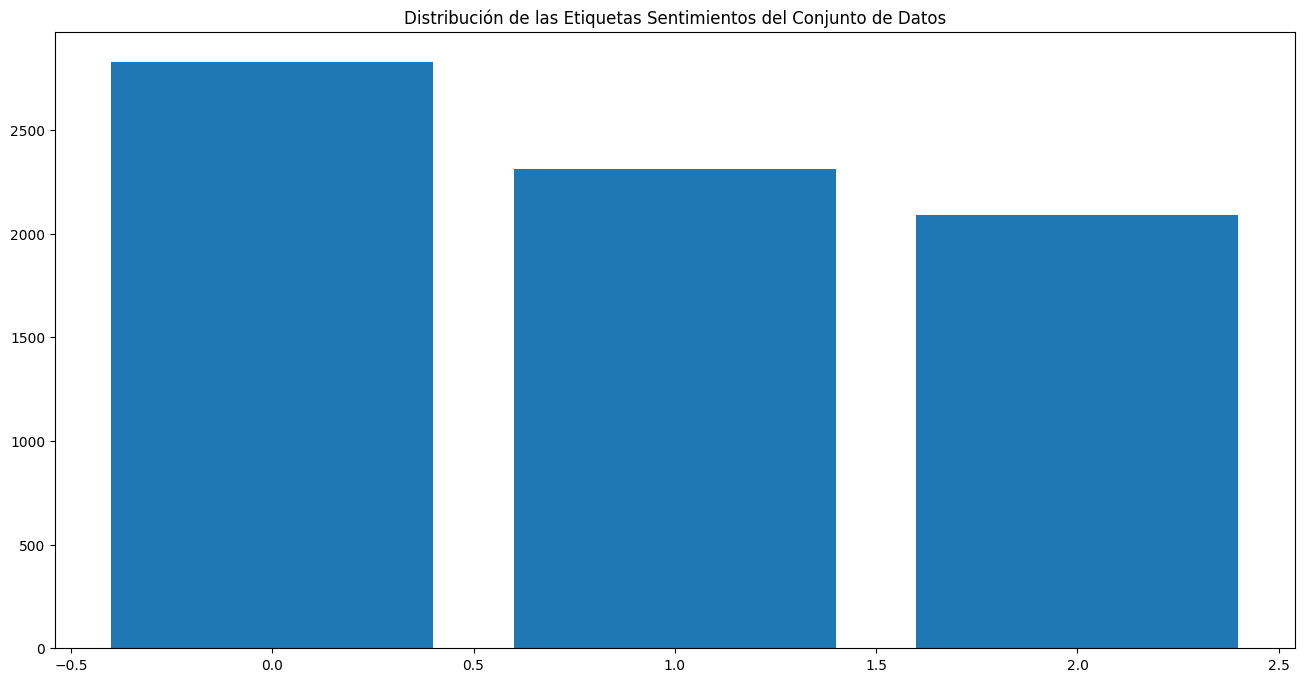

In [9]:
target_cnt = Counter(df.sentiment)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Distribución de las Etiquetas Sentimientos del Conjunto de Datos")

<AxesSubplot: title={'center': 'Gráfico circular de las Etiquetas Sentimientos'}, ylabel='sentiment'>

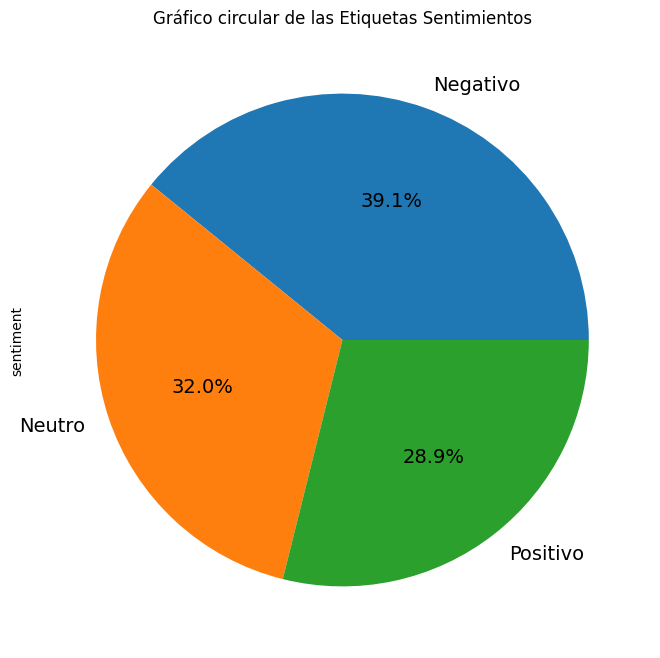

In [10]:
df2=df.copy(deep=True)
pie1=pd.DataFrame(df2['sentiment'].replace(0,'Negativo').replace(1,'Neutro').replace(2,'Positivo').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Gráfico circular de las Etiquetas Sentimientos',y = 'sentiment', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(8,8))

In [11]:
sns.set(style = "white" , font_scale = 1.2)

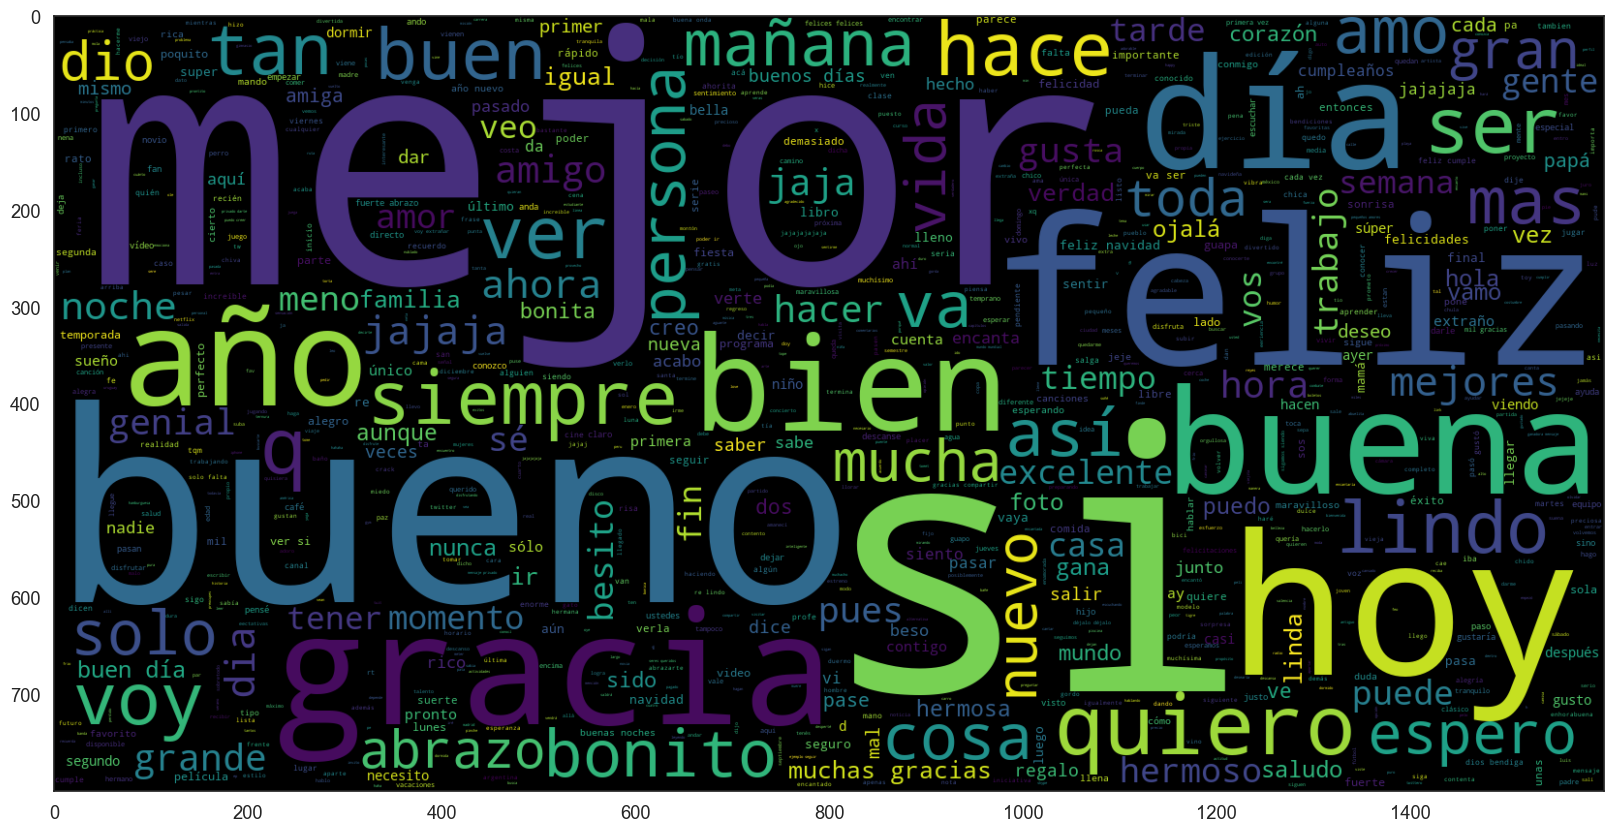

In [12]:
#Wordcloud for positive text (label -1)
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 2].text))
plt.imshow(wc , interpolation = 'bilinear')

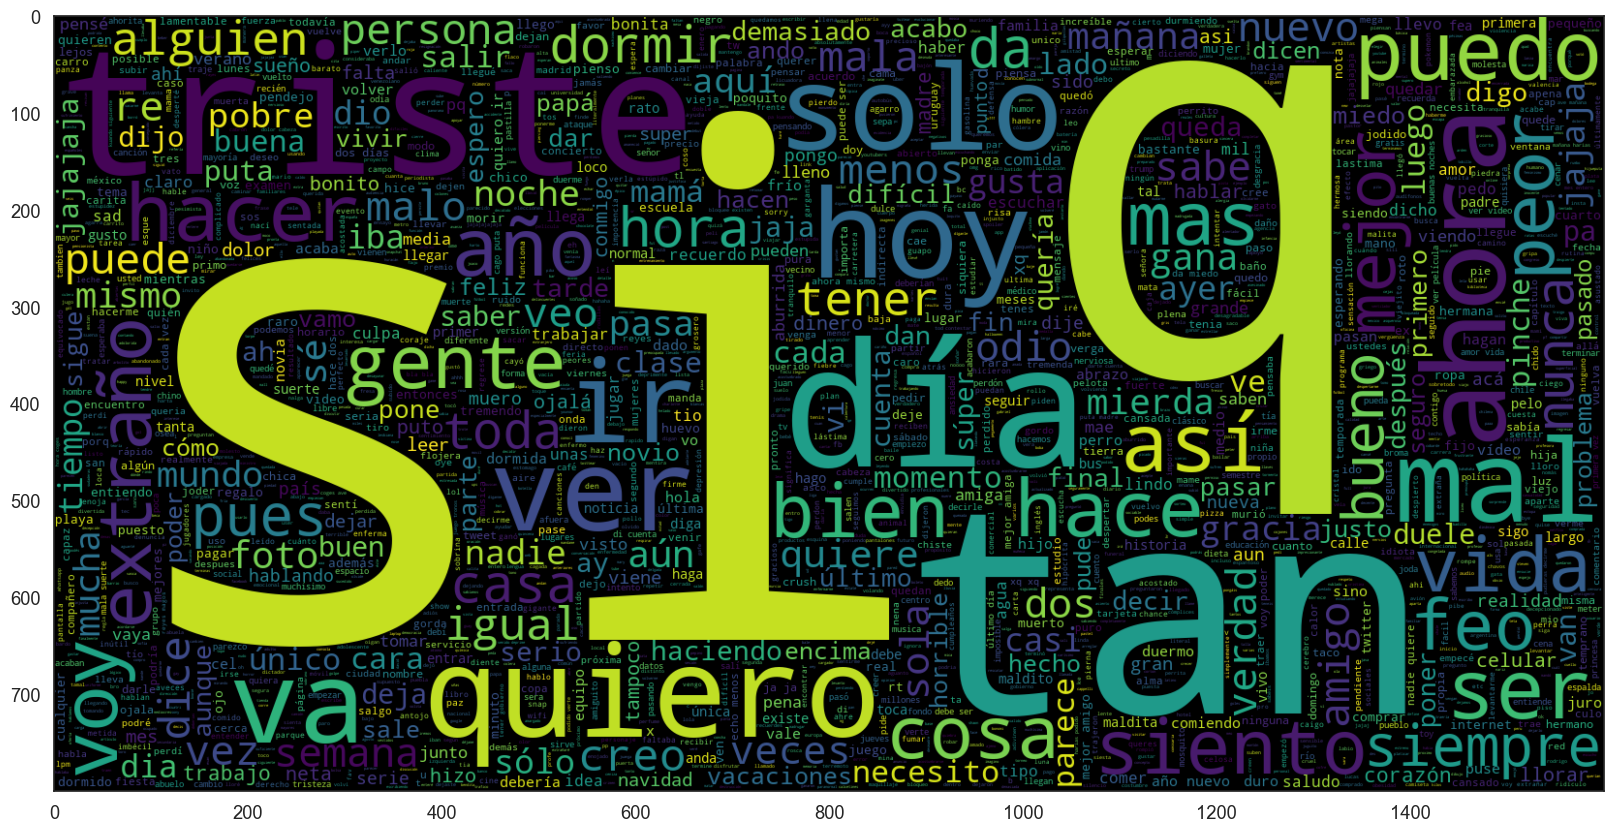

In [13]:
#Wordcloud for negative text (label 0)
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

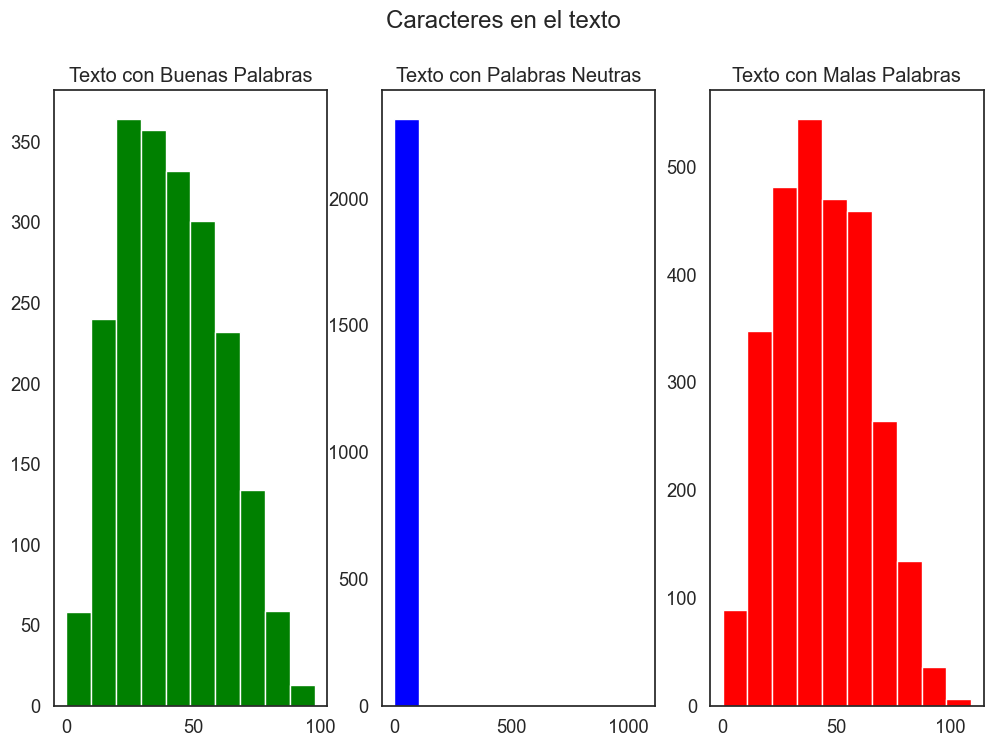

In [14]:
#Numero de caracteres en el texto
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,8))
text_len=df[df['sentiment']==2]['text'].str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Texto con Buenas Palabras')
text_len=df[df['sentiment']==1]['text'].str.len()
ax2.hist(text_len,color='blue')
ax2.set_title('Texto con Palabras Neutras')
text_len=df[df['sentiment']==0]['text'].str.len()
ax3.hist(text_len,color='red')
ax3.set_title('Texto con Malas Palabras')
fig.suptitle('Caracteres en el texto')
plt.show()


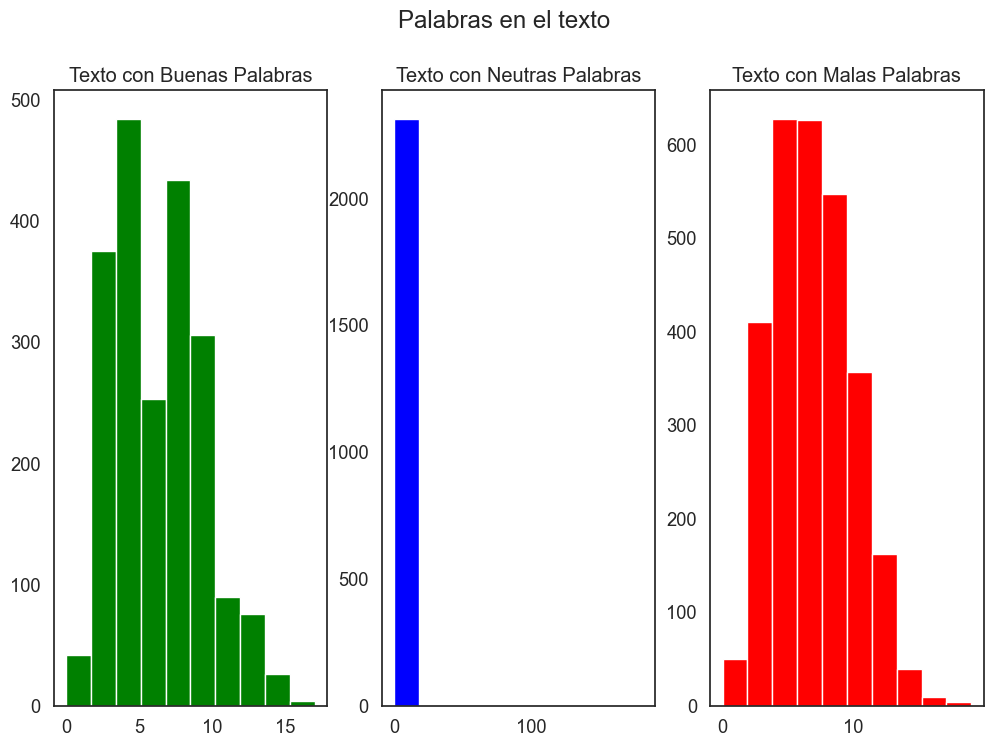

In [15]:
#Numero de palabras en el texto
fig,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(12,8))
text_len=df[df['sentiment']==2]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Texto con Buenas Palabras')
text_len=df[df['sentiment']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='blue')
ax2.set_title('Texto con Neutras Palabras')
text_len=df[df['sentiment']==0]['text'].str.split().map(lambda x: len(x))
ax3.hist(text_len,color='red')
ax3.set_title('Texto con Malas Palabras')
fig.suptitle('Palabras en el texto')
plt.show()

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/4n/qkys9ydn1yj99mfng55ds7br0000gn/T/ipykernel_3712/1110833901.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: M

Text(0.5, 0.98, 'Longitud media de las palabras en el texto')

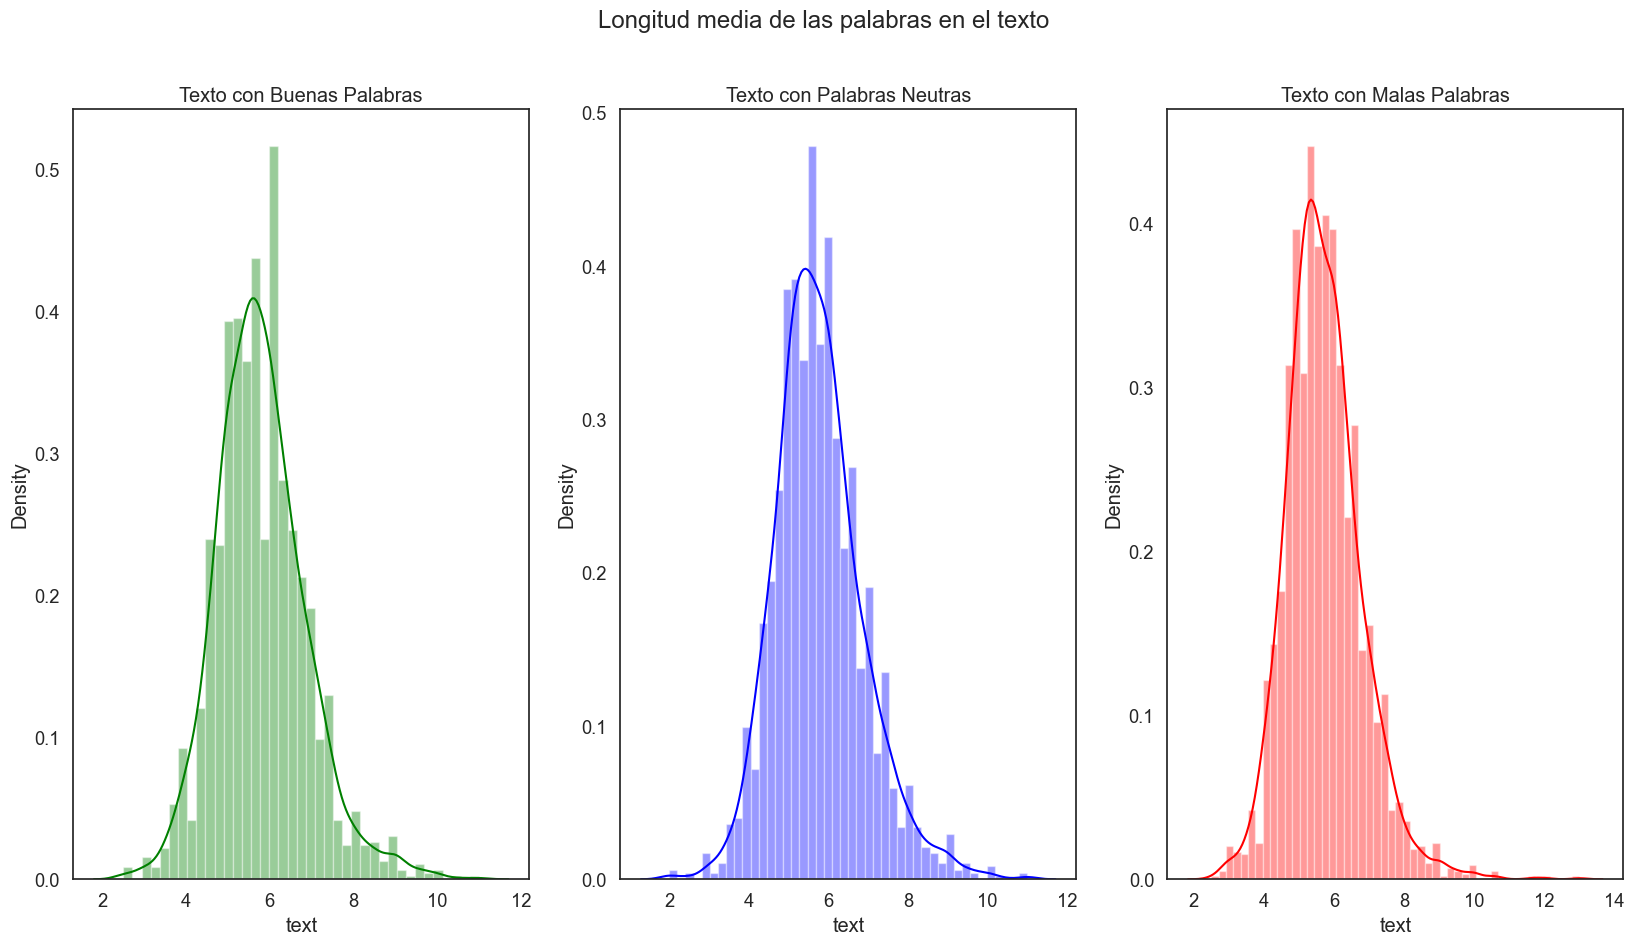

In [16]:
#Longitud media de las palabras en el texto
fig,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(20,10))
word=df[df['sentiment']==2]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('Texto con Buenas Palabras')
word=df[df['sentiment']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='blue')
ax2.set_title('Texto con Palabras Neutras')
word=df[df['sentiment']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='red')
ax3.set_title('Texto con Malas Palabras')
fig.suptitle('Longitud media de las palabras en el texto')

In [17]:
#Palabras mas repetidas en los textos

def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:10]

['escena',
 'documentales',
 'respetados',
 'naturaleza',
 'dudo',
 'feo',
 'tener',
 'terminar',
 'dos',
 'personas']

In [18]:
#Contamos las 10 palabras mas repetidas en los textos

from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'si': 614,
 'q': 317,
 'hoy': 287,
 'quiero': 286,
 'mejor': 271,
 'día': 249,
 'ser': 245,
 'tan': 243,
 'ver': 239,
 'solo': 231}

In [19]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [20]:
df.head()

,text,sentiment
0,escena documentales respetados naturaleza dudo,2
1,feo tener terminar dos personas aún aman entorno,0
2,oído mcdonalds mejor mannequin challenge visto...,0
3,aceptar hundiendo consumismo nueva macbook gop...,1
4,mmm quiero hacer spoiler hoy va ver nuevo podr...,1


In [21]:
most_common_uni = get_top_text_ngrams(df.text,20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Palabras_comunes"] = list(most_common_uni.keys())
temp["Contador"] = list(most_common_uni.values())
fig = px.bar(temp, x="Contador", y="Palabras_comunes", title='Palabras (1) Repetidas en el Texto', orientation='h', 
             width=700, height=700,color='Palabras_comunes')
fig.show()

In [22]:
most_common_bi = get_top_text_ngrams(df.text,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Palabras_comunes" , 'Contador'])
temp["Palabras_comunes"] = list(most_common_bi.keys())
temp["Contador"] = list(most_common_bi.values())
fig = px.bar(temp, x="Contador", y="Palabras_comunes", title='Palabras (2) Repetidas en el Texto', orientation='h', 
             width=700, height=700,color='Palabras_comunes')
fig.show()

In [23]:
most_common_tri = get_top_text_ngrams(df.text,20,3)
most_common_tri = dict(most_common_tri)
temp = pd.DataFrame(columns = ["Palabras_comunes" , 'Contador'])
temp["Palabras_comunes"] = list(most_common_tri.keys())
temp["Contador"] = list(most_common_tri.values())
fig = px.bar(temp, x="Contador", y="Palabras_comunes", title='Palabras (3) Repetidas en el Texto', orientation='h', 
             width=700, height=700,color='Palabras_comunes')
fig.show()

Text(0.5, 0.98, 'Histograma Numero de Palabras en Texto')

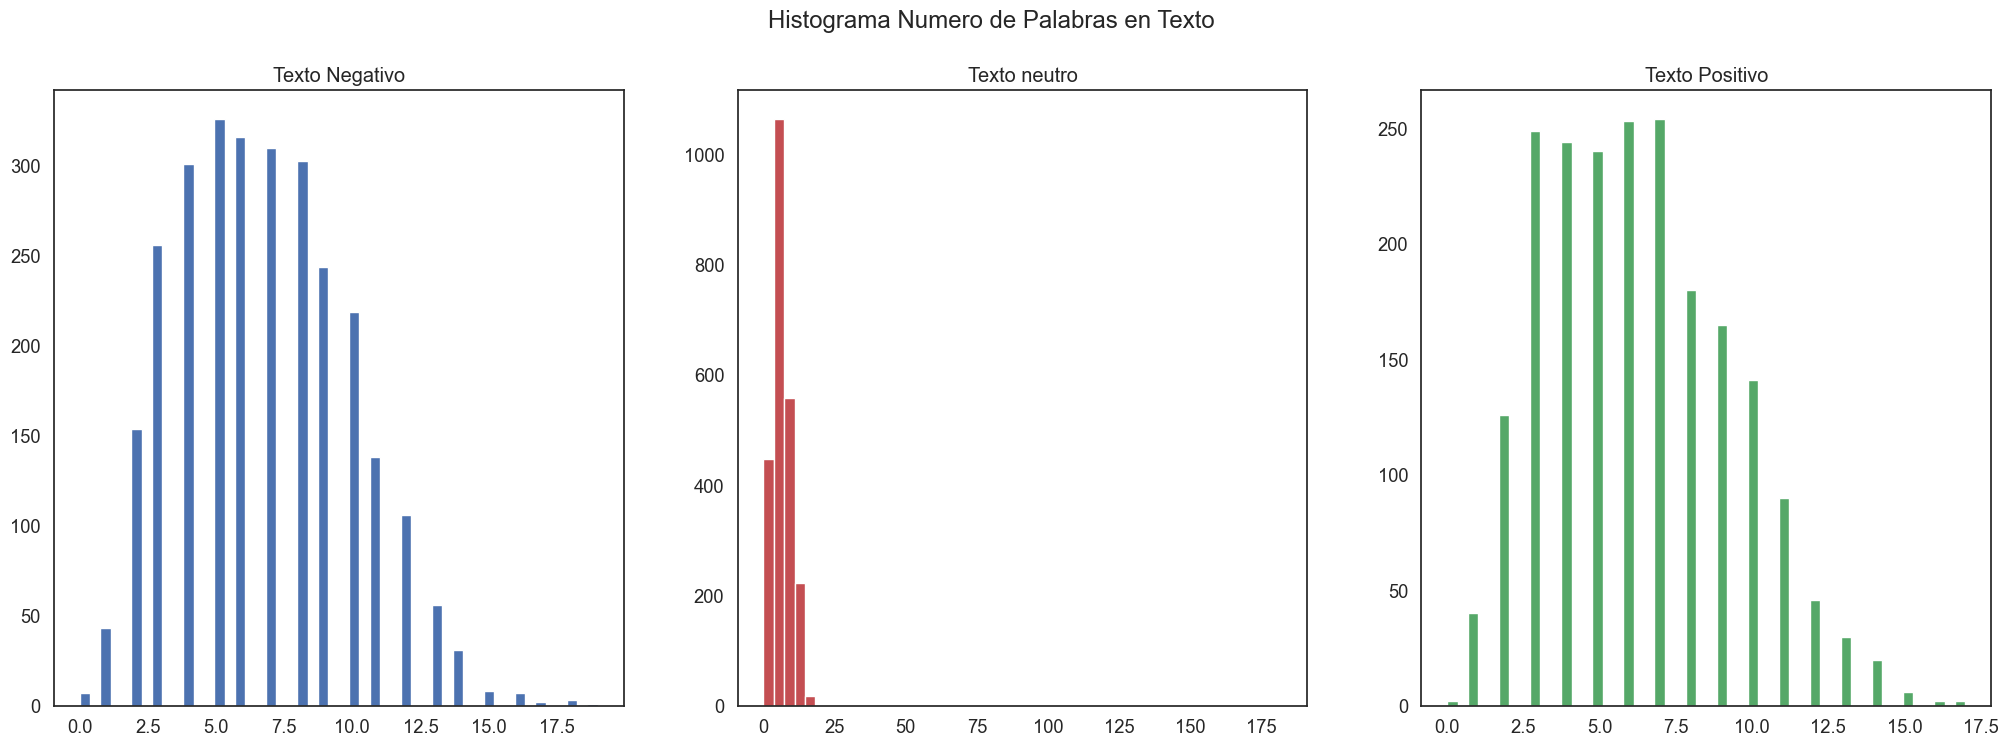

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,8))

ax1.hist(df[df['sentiment'] == 0]['text'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Texto Negativo')

ax2.hist(df[df['sentiment'] == 1]['text'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Texto neutro')

ax3.hist(df[df['sentiment'] == 2]['text'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Texto Positivo')

f.suptitle('Histograma Numero de Palabras en Texto')

In [25]:
df['text'].str.split().map(lambda x: len(x)).max()

182

In [26]:
dfff=pd.DataFrame(df['text'].str.split().map(lambda x: len(x))>=6)
print('Numero de frases que contienen mas de 6 palabras: ', dfff.loc[dfff['text']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['text'].str.split().map(lambda x: len(x))>=10)
print('Numero de frases que contienen mas de 10 palabras: ', dfff.loc[dfff['text']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['text'].str.split().map(lambda x: len(x))>=12)
print('Numero de frases que contienen mas de 12 palabras: ', dfff.loc[dfff['text']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['text'].str.split().map(lambda x: len(x))>=14)
print('Numero de frases que contienen mas de 14 palabras: ', dfff.loc[dfff['text']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['text'].str.split().map(lambda x: len(x))==18)
print('Numero de frases que contienen 18 palabras: ', dfff.loc[dfff['text']==True].shape[0])
print(' ')

Numero de frases que contienen mas de 6 palabras:  4253
 
Numero de frases que contienen mas de 10 palabras:  1284
 
Numero de frases que contienen mas de 12 palabras:  465
 
Numero de frases que contienen mas de 14 palabras:  123
 
Numero de frases que contienen 18 palabras:  3
 


In [27]:
df.sentiment.value_counts()

0    2831
1    2313
2    2090
Name: sentiment, dtype: int64

In [28]:
df_train = pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TFG/Task1-train-dev/train_dev/train_all.csv')

In [30]:
df_train.head()

,text,sentiment
0,@dianalaa32 Es una escena de uno de los docume...,P
1,Qué feo es tener que terminar con alguien; y m...,N
2,"Oído en McDonalds ""el mejor mannequin challeng...",N
3,Tengo que aceptar que me esta hundiendo el con...,NEU
4,Mmm no quiero hacer spoiler pero hoy va a ver ...,NEU


In [31]:
#Environment stopwords
stop = set(stopwords.words('spanish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Data cleaning stopwords (ignored)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df_train['text']=df_train['text'].apply(denoise_text)

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [32]:
df_train.sentiment.replace("P" , 2 , inplace = True)
df_train.sentiment.replace("N" , 0 , inplace = True)
df_train.sentiment.replace("NEU" , 1, inplace = True)
df_train.head()

,text,sentiment
0,escena documentales respetados naturaleza dudo,2
1,feo tener terminar dos personas aún aman entorno,0
2,oído mcdonalds mejor mannequin challenge visto...,0
3,aceptar hundiendo consumismo nueva macbook gop...,1
4,mmm quiero hacer spoiler hoy va ver nuevo podr...,1


<AxesSubplot: title={'center': 'Gráfico circular de las Etiquetas Sentimientos'}, ylabel='sentiment'>

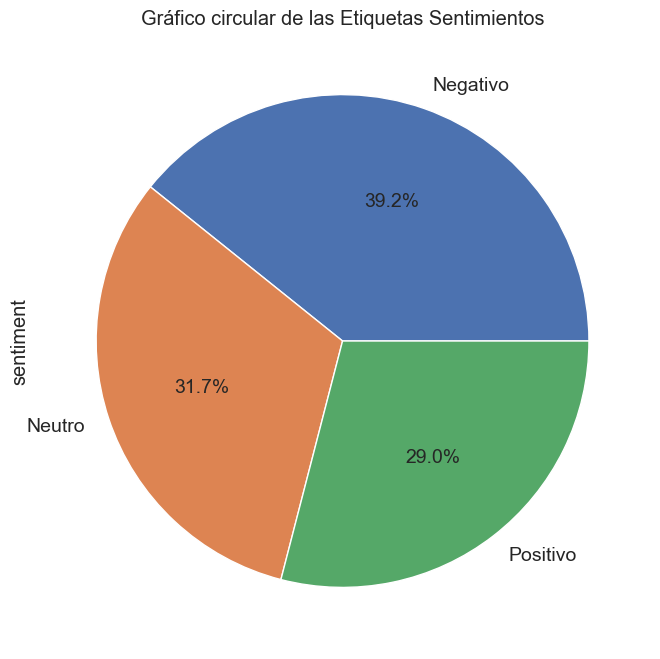

In [33]:
df2=df_train.copy(deep=True)
pie1=pd.DataFrame(df2['sentiment'].replace(0,'Negativo').replace(1,'Neutro').replace(2,'Positivo').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Gráfico circular de las Etiquetas Sentimientos',y = 'sentiment', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(8,8))

In [36]:
review = df_train['text']
label = df_train['sentiment']

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(review, label, stratify=label, test_size=0.2)

In [51]:
df_test = pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TFG/Task1-train-dev/train_dev/dev_all.csv')

In [52]:
df_test.head()

,text,sentiment
0,@sergiocaycho hay que vernos porfa,NEU
1,Esperando el metropolitano hace 26 minutos,N
2,No fue fácil pero la vida sigue,NEU
3,Levántate a hacer pis y de paso háblame,NEU
4,Al final el tiempo terminó por darme la razón,NEU


In [53]:
#Environment stopwords
stop = set(stopwords.words('spanish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Data cleaning stopwords (ignored)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df_test['text']=df_test['text'].apply(denoise_text)

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [54]:
df_test.sentiment.replace("P" , 2 , inplace = True)
df_test.sentiment.replace("N" , 0 , inplace = True)
df_test.sentiment.replace("NEU" , 1, inplace = True)
df_test.head()

,text,sentiment
0,vernos porfa,1
1,esperando metropolitano hace minutos,0
2,fácil vida sigue,1
3,levántate hacer pis paso háblame,1
4,final tiempo terminó darme razón,1


<AxesSubplot: title={'center': 'Gráfico circular de las Etiquetas Sentimientos'}, ylabel='sentiment'>

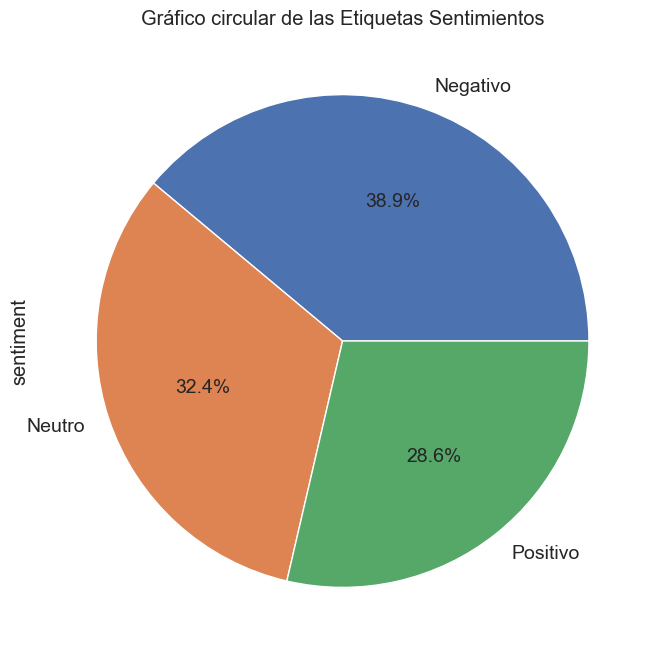

In [55]:
df2=df_test.copy(deep=True)
pie1=pd.DataFrame(df2['sentiment'].replace(0,'Negativo').replace(1,'Neutro').replace(2,'Positivo').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Gráfico circular de las Etiquetas Sentimientos',y = 'sentiment', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(8,8))

In [56]:
df_test.to_csv('test_all.csv')